In [1]:
#-- import modules--

import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import math
import astropy_healpix as ah
from astropy import units as u
import healpy as hp
import ligo.skymap.plot           
from ligo.skymap.tool import ArgumentParser, FileType
from ligo.skymap.io import fits
from ligo.skymap.tool import ligo_skymap_contour
from ligo.skymap.postprocess import contour
from ligo.skymap import postprocess
from astropy.coordinates import SkyCoord
from astropy.time import Time
import scipy.stats as st
from scipy.optimize import bisect

from ligo.skymap import io
from ligo.skymap.bayestar import rasterize
from ligo.skymap import version
from astropy.table import Table
from astropy.time import Time
import numpy as np
import os
import sys
import pickle
from ligo.skymap.kde import Clustered2Plus1DSkyKDE, Clustered2DSkyKDE
import logging
from textwrap import wrap
from pycbc.detector import Detector

In [2]:
def create_fits_file(noise_case, network, ra_samps, dec_samps, ci=90):
    
    #-- samples for calculating KDE --
    pts = np.column_stack((ra_samps, dec_samps)) 
    
    #-- KDE function params
    trials = 5
    jobs = 10
    
    #-- Evaluating ClusteredKDE using a k-means clustering algorithm
    
    skypost = Clustered2DSkyKDE(pts, trials=trials, jobs=trials)

    hpmap = skypost.as_healpix(top_nside=16)
    
    #-- writing and saving the fits files --
    io.write_sky_map(os.getcwd() + '/fits_files/noise_{}_{}_GW170817_skymap.fits.gz'.format(noise_case, network), hpmap, nest=True)

    return None

In [4]:
#-- reading PE samples --

def pos_samples(filename):
    
    file = h5py.File(filename, 'r')

    mchirp, q, chi_eff = np.array(file['Mc']), np.array(file['mass_ratio']), np.array(file['chi_eff'])    
    iota, ra, dec = np.array(file['iota']), np.array(file['ra']), np.array(file['dec'])
    z =  np.array(file['z'])
    dL =  np.array(file['dL'])
        
    return np.column_stack((mchirp, chi_eff, iota, ra, dec, dL, z)), np.column_stack((mchirp, q, chi_eff, iota, ra, dec, dL, z))


In [5]:
os.getcwd()

'/home/sachins/work/LIGO_India/bns_nsbh_gwtc/tarang/test_GWTC/GW200115_NSBH/meshfree/comparison/skymaps'

In [6]:
#-- reading post_samples --

noise_case = 1500

samps_LHV, _ = pos_samples(os.getcwd() + '/../../LHV/post_samples/post_samples_interp_L1H1V1_{}.hdf'.format(noise_case))
                        
samps_LHVA, _ = pos_samples(os.getcwd() + '/../../LHVA/post_samples/post_samples_interp_L1H1V1A0_{}.hdf'.format(noise_case))



In [10]:
#-- ra & dec samps --

LHV_ra_samps,LHV_dec_samps = samps_LHV[:,3], samps_LHV[:,4]

LHVA_ra_samps,LHVA_dec_samps = samps_LHVA[:,3], samps_LHVA[:,4]


In [11]:
networks = {'LHV': [LHV_ra_samps, LHV_dec_samps] , 'LHVA': [LHVA_ra_samps, LHVA_dec_samps]}

for key, vals in networks.items():
    
    network = key
    ra_samps = vals[0]
    dec_samps = vals[1]
    create_fits_file(noise_case=noise_case, network=network, ra_samps=ra_samps, dec_samps=dec_samps, ci=90)

  0%|          | 0/200 [00:00<?, ?it/s]

adaptive refinement round 1 of 7 ...
adaptive refinement round 2 of 7 ...
adaptive refinement round 3 of 7 ...
adaptive refinement round 4 of 7 ...
adaptive refinement round 5 of 7 ...
adaptive refinement round 6 of 7 ...
adaptive refinement round 7 of 7 ...


  0%|          | 0/200 [00:00<?, ?it/s]

adaptive refinement round 1 of 7 ...
adaptive refinement round 2 of 7 ...
adaptive refinement round 3 of 7 ...
adaptive refinement round 4 of 7 ...
adaptive refinement round 5 of 7 ...
adaptive refinement round 6 of 7 ...
adaptive refinement round 7 of 7 ...


In [2]:
#-- injected parameters --

ra = 0.721    # radians
dec = -0.021   # radians

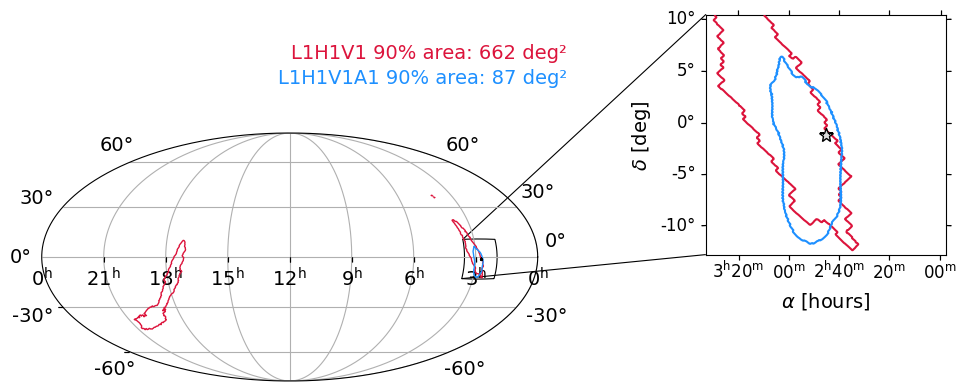

In [5]:
#-- ASTRO MOLLWEIDE PROJECTION --

fontsize = 14

#-- plotting arguments ----
axes_args = {}
axes_args['projection'] = 'astro hours'
axes_args['projection'] += ' ' + 'mollweide'

ax = plt.axes(**axes_args)
ax.grid()
ax.tick_params(which='both', labelsize=fontsize)

methods = ['L1H1V1', 'L1H1V1A1']
colors = ['crimson', 'dodgerblue']

skymap = {}
metadata = {}
nside = {}
text = {}
vals = {}
cs = {}
deg2perpix = {}
probperdeg = {}

levels = [90] # credible levels
pp = np.round([levels[0]])#.astype(int)
lw = 1.5
noise_case=1900
j = 0
for m in methods:
    
    skymap[m], metadata[m] =  fits.read_sky_map(os.getcwd() + '/fits_files/noise_{}_GW200115_{}_skymap.fits.gz'.format(noise_case, m), nest=None)
    nside[m] = ah.npix_to_nside(len(skymap[m]))
    
    #--Convert sky map from probability to probability per square degree ---
    deg2perpix[m] = ah.nside_to_pixel_area(nside[m]).to_value(u.deg**2)
    probperdeg[m] = skymap[m] / deg2perpix[m]
    
    vals[m] = 100 * postprocess.find_greedy_credible_levels(skymap[m])
    cs[m] = ax.contour_hpx((vals[m], 'ICRS'), nested=metadata[m]['nest'], colors=colors[j], linewidths=1, levels=levels)

    #-- for printing the '' % credible region on the globe ---
    fmt = '%g%%'            
    text[m] = []  
    
    #-- for area of 90% credible region ---
    ii = np.round(np.searchsorted(np.sort(vals[m]), [levels[0]]) * deg2perpix[m]).astype(int)

    for i, p in zip(ii, pp):

     #   text[m].append('{} {:d}% area: {:,.2f} deg²'.format(m, p, i))    # for typing 90% credible area value in plot
        text[m].append('{} {:d}% area: {:,d} deg²'.format(m, p, i)) 
    j += 1

# ax.imshow_hpx((probperdeg['PyCBC'], 'ICRS'), nested=metadata['PyCBC']['nest'], cmap='PuBu')

#-- putting legends on the skymaps ---
ax.text(1.059, 1.30, '\n'.join(text[methods[0]]), transform=ax.transAxes, ha='right', color=colors[0], fontsize=fontsize)
ax.text(1.059, 1.20, '\n'.join(text[methods[1]]), transform=ax.transAxes, ha='right', color=colors[1], fontsize=fontsize)

#-- for injected ra, dec ---
ax.plot_coord(SkyCoord(ra, dec, unit='rad'), '*', markerfacecolor='gainsboro', markeredgecolor='black', markersize=2)

#-- Axes Inset ---
#center = SkyCoord.from_name("NGC 4993")  # in degrees
ra_deg = ra*(180/np.pi)
dec_deg = dec*(180/np.pi)

ax_inset = plt.axes([1.1, 0.5, 0.5, 0.5], projection='astro zoom', center=SkyCoord(ra_deg, dec_deg, unit="deg"), radius=12*u.deg)
# ax_inset.tick_params(which='both', labelsize=fontsize)
# ax_inset.tick_params(which='both', labelsize=fontsize)
ax_inset.set_xlabel(r'$\alpha$ [hours]', fontsize=fontsize)
ax_inset.set_ylabel(r'$\delta$ [deg]', fontsize=fontsize)
ax_inset.tick_params(labelsize=fontsize-2)

ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')

j = 0
for m in methods:
    ax_inset.contour_hpx((vals[m], 'ICRS'), nested=metadata[m]['nest'], colors=colors[j], linewidths=lw, levels=levels)
    j += 1

ax_inset.plot_coord(SkyCoord(ra, dec, unit='rad'), '*', markerfacecolor='gainsboro', markeredgecolor='black', markersize=10)   # for host galaxy

#ax_inset.imshow_hpx((probperdeg['LHVA'], 'ICRS'), nested=metadata['LHVA']['nest'], cmap='PuBu')

plt.savefig("lalit_mollweide_inset_{}_GW200115_skymaps_LHV_LHVA.png".format(noise_case), dpi=200, bbox_inches='tight')
plt.show()

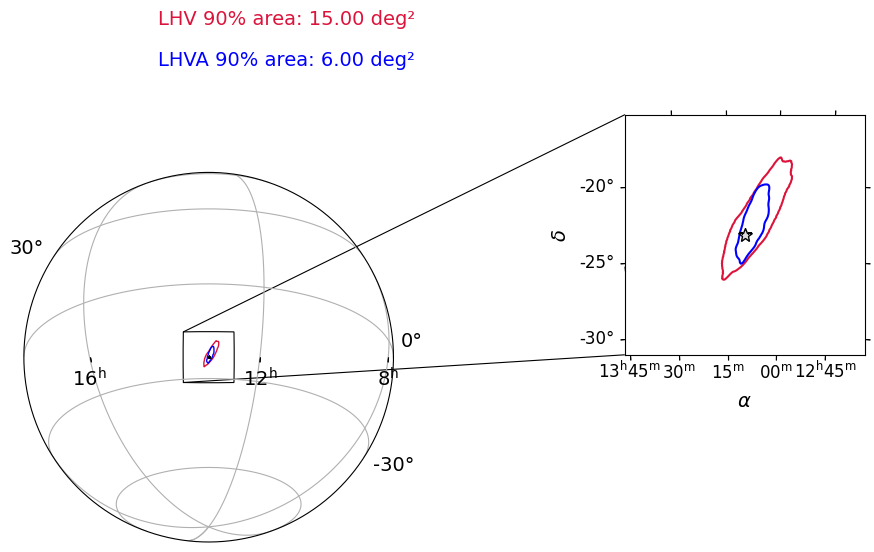

In [12]:
#-- ASTRO GLOBE PROJECTION --

fontsize = 14

#-- plotting arguments ----
axes_args = {}
axes_args['projection'] = 'astro hours'
axes_args['projection'] += ' ' + 'globe'
axes_args['center'] = SkyCoord(ra, dec, unit='rad')    # This coordinate is chosen so that the broken ring in 2 Det case is visible 
ax = plt.axes(**axes_args)
ax.grid()
ax.tick_params(which='both', labelsize=fontsize)

methods = ['LHV', 'LHVA']
colors = ['crimson', 'blue']

skymap = {}
metadata = {}
nside = {}
text = {}
vals = {}
cs = {}
deg2perpix = {}
probperdeg = {}

levels = [90] # credible levels
pp = np.round([levels[0]])#.astype(int)
lw = 1.5

noise_case = 400
j = 0

for m in methods:
    
    skymap[m], metadata[m] =  fits.read_sky_map(os.getcwd() + '/fits_files/noise_{}_GW200115_{}_skymap.fits.gz'.format(noise_case, m), nest=None)
    nside[m] = ah.npix_to_nside(len(skymap[m]))
    
    #--Convert sky map from probability to probability per square degree ---
    deg2perpix[m] = ah.nside_to_pixel_area(nside[m]).to_value(u.deg**2)
    probperdeg[m] = skymap[m] / deg2perpix[m]
    
    vals[m] = 100 * postprocess.find_greedy_credible_levels(skymap[m])
    cs[m] = ax.contour_hpx((vals[m], 'ICRS'), nested=metadata[m]['nest'], colors=colors[j], linewidths=1, levels=levels)

    #-- for printing the '' % credible region on the globe ---
    fmt = '%g%%'            
    text[m] = []  
    
    #-- for area of 90% credible region ---
    ii = np.round(np.searchsorted(np.sort(vals[m]), [levels[0]]) * deg2perpix[m]).astype(int)

    for i, p in zip(ii, pp):

        text[m].append('{} {:d}% area: {:,.2f} deg²'.format(m, p, i))    # for typing 90% credible area value in plot
        
    j += 1

# ax.imshow_hpx((probperdeg['PyCBC'], 'ICRS'), nested=metadata['PyCBC']['nest'], cmap='PuBu')

#-- putting legends on the skymaps ---
ax.text(1.059, 1.40, '\n'.join(text[methods[0]]), transform=ax.transAxes, ha='right', color=colors[0], fontsize=fontsize)
ax.text(1.059, 1.29, '\n'.join(text[methods[1]]), transform=ax.transAxes, ha='right', color=colors[1], fontsize=fontsize)

#-- for injected ra, dec ---
ax.plot_coord(SkyCoord(ra, dec, unit='rad'), '*', markerfacecolor='gainsboro', markeredgecolor='black', markersize=2)

#-- Axes Inset ---
#center = SkyCoord.from_name("NGC 4993")  # in degrees
ra_deg = ra*(180/np.pi)
dec_deg = dec*(180/np.pi)

ax_inset = plt.axes([1.1, 0.5, 0.5, 0.5], projection='astro zoom', center=SkyCoord(ra_deg, dec_deg, unit="deg"), radius=8*u.deg)
# ax_inset.tick_params(which='both', labelsize=fontsize)
# ax_inset.tick_params(which='both', labelsize=fontsize)
ax_inset.set_xlabel(r'$\alpha$ [hours]', fontsize=fontsize)
ax_inset.set_ylabel(r'$\delta$ [deg]', fontsize=fontsize)
ax_inset.tick_params(labelsize=fontsize-2)

ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')

j = 0
for m in methods:
    ax_inset.contour_hpx((vals[m], 'ICRS'), nested=metadata[m]['nest'], colors=colors[j], linewidths=lw, levels=levels)
    j += 1

ax_inset.plot_coord(SkyCoord(ra, dec, unit='rad'), '*', markerfacecolor='gainsboro', markeredgecolor='black', markersize=10)   # for host galaxy
# ax_inset.imshow_hpx((probperdeg['PyCBC'], 'ICRS'), nested=metadata['PyCBC']['nest'], cmap='PuBu'

#plt.savefig("GW190425_k_{}_skymaps_LHV_LHVA.png".format(noise_case), dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
def skymap_credible_area(count, ra_samps, dec_samps, ci=90):
    
    """Function to get desired level credible region skymap area. By default, calculates 90% credible sky area.
    It also creates and stores '.fits' files according to the injection number in a separate folder('fits files')
    
    Parameters
    ----------
    count    : injection number
    ra_samps : posterior samples for right ascension
    dec_samps: posterior samples for declination
    ci       : credible interval (default = 90%)
    
    Returns
    -------
    area : 90% credible region in delta_omega**2 """
    
    #-- samples for calculating KDE --
    pts = np.column_stack((ra_samps, dec_samps)) 
    
    #-- KDE function params
    trials = 1
    jobs = 1
    
    #-- Evaluating ClusteredKDE using a k-means clustering algorithm
    
    skypost = Clustered2DSkyKDE(pts, trials=trials, jobs=trials)

    hpmap = skypost.as_healpix(top_nside=16)
    
    #-- writing and saving the fits files --
    io.write_sky_map(os.getcwd() + '/fits_files/injection_{}_skymap.fits.gz'.format(count), hpmap, nest=True)

    #-- Calculating the skymap area from Healpix map --

    skymap, metadata = fits.read_sky_map(os.getcwd() + '/fits_files/injection_{}_skymap.fits.gz'.format(count), nest=None)
    nside = ah.npix_to_nside(len(skymap))

    #-- Convert sky map from probability to probability per square degree.

    deg2perpix = ah.nside_to_pixel_area(nside).to_value(u.deg**2)
    probperdeg = skymap / deg2perpix

    levels = [ci]   # this should be provided as a list
                    #(see: https://github.com/lpsinger/ligo.skymap/blob/main/ligo/skymap/tool/ligo_skymap_plot.py)

    #-- for contours 
    vals = 100 * postprocess.find_greedy_credible_levels(skymap)

    #-- for area of 90% credible region 

    pp = np.round([ci]).astype(int)               
    area = (np.searchsorted(np.sort(vals), [ci]) * deg2perpix)[0]
    
    return area